#**Enhancing Aspect-Level Sentiment Analysis in Recipe Reviews using Pre-trained Transformer Models**

In this project we implement an aspect-level sentiment analysis model with pre-trained DistilBert and LSTM.

Process:
- Libraries are imported
- Load the data
- Data Preprocessing
  - Tokenization
  - Encoding (mask sentence and aspect, one-hot encode labels)
- Model Architecture Design
- Model Training
- Model Evaluation
- Visualization of Aspect - Sentiment Distributions



In [1]:
#import keras libraries
import keras
import numpy as np
from keras.layers import Lambda, GlobalAveragePooling1D, Dense, Embedding
from keras import backend as K
from keras.models import Sequential
import matplotlib.pyplot as plt

from keras.layers import LSTM, Dropout, Input, Bidirectional, GlobalMaxPooling1D
from keras.layers.core import Dense
from keras.models import Model


In [ ]:
#import libraries
import json
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.metrics import classification_report

Install HuggingFace Transformer model

In [2]:
pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 32.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 34.9 MB/s eta 0:00:00


## Loading Data

### Downloading and preprocessing data

In [4]:
#loading data from google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:


raw_data = json.load(open("/content/drive/My Drive/Aspect Term Extraction and Polarity Classification.FAST_LCF_ATEPC.result.json","rb"))

#file = pd.read_csv("/content/drive/My Drive/filename.ext")

#load data locally from notebook
#raw_data = pd.read_json("Aspect Term Extraction and Polarity Classification.FAST_LCF_ATEPC.result.json",
                        #lines=True,
                        #orient='columns')

# convert .json file to a dataframe
df = pd.json_normalize(raw_data)

result = df.explode(["aspect", "position", "sentiment","confidence"]).reset_index(drop=True)

result.head()


,sentence,IOB,tokens,aspect,position,sentiment,probs,confidence
0,better than any you can get at a restaurant !,"[O, O, O, O, O, O, O, O, B-ASP, O]","[better, than, any, you, can, get, at, a, rest...",restaurant,[8],Negative,"[[0.9167701005935669, 0.059350572526454926, 0....",0.9168
1,"I cut back on the mayo , and made up the diffe...","[O, O, O, O, O, B-ASP, O, O, O, O, O, O, O, B-...","[I, cut, back, on, the, mayo, ,, and, made, up...",mayo,[5],Neutral,"[[0.24266134202480316, 0.7432963848114014, 0.0...",0.7433
2,"I cut back on the mayo , and made up the diffe...","[O, O, O, O, O, B-ASP, O, O, O, O, O, O, O, B-...","[I, cut, back, on, the, mayo, ,, and, made, up...",sour cream,"[13, 14]",Neutral,"[[0.24266134202480316, 0.7432963848114014, 0.0...",0.5857
3,"I cut back on the mayo , and made up the diffe...","[O, O, O, O, O, B-ASP, O, O, O, O, O, O, O, B-...","[I, cut, back, on, the, mayo, ,, and, made, up...",dip,[21],Neutral,"[[0.24266134202480316, 0.7432963848114014, 0.0...",0.938
4,i think i did something wrong because i could ...,"[O, O, O, O, O, O, O, O, O, O, O, B-ASP, O, O,...","[i, think, i, did, something, wrong, because, ...",cornstarch,[11],Negative,"[[0.8502517342567444, 0.14207318425178528, 0.0...",0.8503


In [6]:
#df = df.drop(df.columns[[0, 1, 3]], axis=1) # df.columns is zero-based pd.Index
dropped_result = result.drop(result.columns[[1, 2, 6, 7]], axis=1)

def swap_columns(dataset, col1, col2):
    col_list = list(df.columns)
    x, y = col_list.index(col1), col_list.index(col2)
    col_list[y], col_list[x] = col_list[x], col_list[y]
    dataset = dataset[col_list]
    return dataset
result = swap_columns(result, 'sentiment', 'position')

dropped_result = result.drop(result.columns[[1, 2, 6, 7]], axis=1)


dropped_result.head()


,sentence,aspect,sentiment,position
0,better than any you can get at a restaurant !,restaurant,Negative,[8]
1,"I cut back on the mayo , and made up the diffe...",mayo,Neutral,[5]
2,"I cut back on the mayo , and made up the diffe...",sour cream,Neutral,"[13, 14]"
3,"I cut back on the mayo , and made up the diffe...",dip,Neutral,[21]
4,i think i did something wrong because i could ...,cornstarch,Negative,[11]


In [7]:
len(dropped_result)

368014

In [8]:
dropped_result.head(20)


,sentence,aspect,sentiment,position
0,better than any you can get at a restaurant !,restaurant,Negative,[8]
1,"I cut back on the mayo , and made up the diffe...",mayo,Neutral,[5]
2,"I cut back on the mayo , and made up the diffe...",sour cream,Neutral,"[13, 14]"
3,"I cut back on the mayo , and made up the diffe...",dip,Neutral,[21]
4,i think i did something wrong because i could ...,cornstarch,Negative,[11]
5,easily the best i have ever had . juicy flavor...,vegetables,Positive,[15]
6,An excellent dish .,dish,Positive,[2]
7,"love it , but without the bean sprouts .",bean sprouts,Negative,"[6, 7]"
8,"chewy goodness , not crispy at all . i even th...",goodness,Negative,[1]
9,"chewy goodness , not crispy at all . i even th...",craisins,Neutral,[12]


In [9]:
# dropping the rows having NaN values
dropped_result = dropped_result.dropna()

# To reset the indices
dropped_result = dropped_result.reset_index(drop=True)

In [10]:
print(len(dropped_result))
dropped_result.head(20)

331046


,sentence,aspect,sentiment,position
0,better than any you can get at a restaurant !,restaurant,Negative,[8]
1,"I cut back on the mayo , and made up the diffe...",mayo,Neutral,[5]
2,"I cut back on the mayo , and made up the diffe...",sour cream,Neutral,"[13, 14]"
3,"I cut back on the mayo , and made up the diffe...",dip,Neutral,[21]
4,i think i did something wrong because i could ...,cornstarch,Negative,[11]
5,easily the best i have ever had . juicy flavor...,vegetables,Positive,[15]
6,An excellent dish .,dish,Positive,[2]
7,"love it , but without the bean sprouts .",bean sprouts,Negative,"[6, 7]"
8,"chewy goodness , not crispy at all . i even th...",goodness,Negative,[1]
9,"chewy goodness , not crispy at all . i even th...",craisins,Neutral,[12]


In [11]:
#randomly split the dataset into train(60%), test(20%) and validation(20%)

train, val, test = \
              np.split(dropped_result.sample(frac=1, random_state=42),
                       [int(.6*len(dropped_result)), int(.8*len(dropped_result))])


In [12]:
train = train.values.tolist()
test = test.values.tolist()
val = val.values.tolist()

In [13]:
print("Training entries: {}".format(len(train)))
print("Test entries: {}".format(len(test)))

print("validation entries: {}".format(len(val)))



Training entries: 198627
Test entries: 66210
validation entries: 66209


## Preprocessing and Tokenization

Use DistilBERT's model tokenizer for tokenization.

Mask aspects and sentences.

In [3]:
from transformers import DistilBertTokenizer, RobertaTokenizer
import tqdm
distil_bert = 'distilbert-base-uncased' # select distilBERT pre-trained model

# Defining DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained(distil_bert, do_lower_case=True, add_special_tokens=True,
                                                max_length=128, pad_to_max_length=True)

def tokenize(sentences, tokenizer, pad_length=128, pad_to_max_length=True ):
    if type(sentences) == str:
        inputs = tokenizer.encode_plus(sentences, add_special_tokens=True, max_length=pad_length, pad_to_max_length=pad_to_max_length,
                                             return_attention_mask=True, return_token_type_ids=True)
        return np.asarray(inputs['input_ids'], dtype='int32'), np.asarray(inputs['attention_mask'], dtype='int32'), np.asarray(inputs['token_type_ids'], dtype='int32')

    input_ids, input_masks, input_segments = [],[],[]
    for sentence in sentences:
        inputs = tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=pad_length, pad_to_max_length=pad_to_max_length,
                                             return_attention_mask=True, return_token_type_ids=True)
        input_ids.append(inputs['input_ids'])
        input_masks.append(inputs['attention_mask'])
        input_segments.append(inputs['token_type_ids'])

    return np.asarray(input_ids, dtype='int32'), np.asarray(input_masks, dtype='int32'), np.asarray(input_segments, dtype='int32')


Tokenize and mask aspects and sentences


In [14]:
#create lists for train set
x_train_review_int = []
x_train_review_masks = []
x_train_aspect_int = []
x_train_aspect_masks = []

#create lists for validation set
x_val_review_int = []
x_val_review_masks = []
x_val_aspect_int = []
x_val_aspect_masks = []

#create lists for test set
x_test_review_int = []
x_test_review_masks = []
x_test_aspect_int = []
x_test_aspect_masks = []

#mask tokenized aspects and sentences by turning them into numeric representations:

#to convert train data
for sent in train:
  ids,masks,segments = tokenize(str(sent[0]), tokenizer, pad_to_max_length=False)
  x_train_review_int.append(ids)
  x_train_review_masks.append(masks)
  ids,masks,segments = tokenize(str(sent[1]), tokenizer, pad_to_max_length=False)
  x_train_aspect_int.append(ids)
  x_train_aspect_masks.append(masks)

#to convert validation data
for sent in val:
  ids,masks,segments = tokenize(str(sent[0]), tokenizer, pad_to_max_length=False)
  x_val_review_int.append(ids)
  x_val_review_masks.append(masks)
  ids,masks,segments = tokenize(str(sent[1]), tokenizer, pad_to_max_length=False)
  x_val_aspect_int.append(ids)
  x_val_aspect_masks.append(masks)

#convert test data
for sent in test:
  ids,masks,segments = tokenize(str(sent[0]), tokenizer, pad_to_max_length=False)
  x_test_review_int.append(ids)
  x_test_review_masks.append(masks)
  ids,masks,segments = tokenize(str(sent[1]), tokenizer, pad_to_max_length=False)
  x_test_aspect_int.append(ids)
  x_test_aspect_masks.append(masks)


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [15]:
len(x_val_aspect_int)

66209

In [16]:

# You can check the results as follows:
assert len(x_train_aspect_int) == len(train)
assert len(x_train_aspect_masks) == len(x_train_aspect_int)
assert len(x_test_aspect_int) == len(test)
assert len(x_test_aspect_masks) == len(x_test_aspect_int)
print("x_val_aspect_int[0]:")
print(x_val_aspect_int[0])
print("x_val_aspect_masks[0]:")
print(x_val_aspect_masks[0])
print("x_val_review_int[0]:")
print(x_val_review_int[0])
print("x_val_review_masks[0]:")
print(x_val_review_masks[0])

x_dev_aspect_int[0]:
[  101 11968  7834  2319   102]
x_dev_aspect_masks[0]:
[1 1 1 1 1]
x_dev_review_int[0]:
[  101  1045  2109  2023  2007 10768  4779 16835  3490  2005  2093  5381
  1998  2009  2001  6669 12984  1010  2794  3103 13626  6340 20856  2063
 20739  2080 12901  2157  2044  1045 11055  1996 24857  2046  1996  8962
  2404  1996 11876  2067  2006  1998  3653 16033  3819 24857  2053 14163
  4757  2053 28554  1011  1997  2607  1045  2794  2070 11968  7834  2319
  2043  3529  1012  4283  5545  2005  1037  2613  2053  3422 17974  2008
  2573   102]
x_dev_review_masks[0]:
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


one-hot encode the labels with binary representations, using 4 (Binary:100) to represent "positive", 2 (Binary:010) for "neutral", and 1 (Binary:001) for "negative".

In [17]:
def label2int(dataset):
  y = []
  for example in dataset:
    if str(example[2]).lower() == "negative":
      y.append([0,0,1])
    elif str(example[2]).lower() == "neutral":
      y.append([0,1,0])
    else:
      y.append([1,0,0])
  return y

y_train = label2int(train)
y_val = label2int(val)
y_test = label2int(test)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

print(y_train[0])
print(y_train[1])
print(y_train[2])

[0 1 0]
[1 0 0]
[0 1 0]
[1 0 0]
[0 1 0]


combine the review and aspect into one sentence and then input it into the model.

In [18]:

x_train_int = []
x_train_masks = []
x_val_int = []
x_val_masks = []
x_test_int = []
x_test_masks = []

#create a new record that contains a concatenation of the text and aspect with special token
x_train_set = []
for sent in train:
  x_train_set.append(str(sent[0]) + ' ' + tokenizer.sep_token + ' ' + str(sent[1]))
x_val_set = []
for sent in val:
  x_val_set.append(str(sent[0]) + ' ' + tokenizer.sep_token + ' ' + str(sent[1]))
x_test_set = []
for sent in test:
  x_test_set.append(str(sent[0]) + ' ' + tokenizer.sep_token + ' ' + str(sent[1]))

#then we extract sentences and aspect words from variable created above, set max pad length to true
for sent in x_train_set:
  ids, masks,segments = tokenize(str(sent), tokenizer, pad_to_max_length = False)
  x_train_int.append(ids)
  x_train_masks.append(masks)

for sent in x_val_set:
  ids, masks,segments = tokenize(str(sent), tokenizer, pad_to_max_length = False)
  x_val_int.append(ids)
  x_val_masks.append(masks)

for sent in x_test_set:
  ids, masks,segments = tokenize(str(sent), tokenizer, pad_to_max_length = False)
  x_test_int.append(ids)
  x_test_masks.append(masks)


x_train_int = np.array(keras.utils.pad_sequences(x_train_int, padding='post', maxlen=128, value=0))
x_train_masks = np.array(keras.utils.pad_sequences(x_train_masks, padding='post', maxlen=128, value=0))
x_val_int = np.array(keras.utils.pad_sequences(x_val_int, padding='post', maxlen=128, value=0))
x_val_masks = np.array(keras.utils.pad_sequences(x_val_masks, padding='post', maxlen=128, value=0))
x_test_int = np.array(keras.utils.pad_sequences(x_test_int, padding='post', maxlen=128, value=0))
x_test_masks = np.array(keras.utils.pad_sequences(x_test_masks, padding='post', maxlen=128, value=0))


# np.array function to wrap the outputs
x_train_int_np = np.array(x_train_int)
x_train_masks_np = np.array(x_train_masks)
x_val_int_np = np.array(x_val_int)
x_val_masks_np = np.array(x_val_masks)
x_test_int_np = np.array(x_test_int)
x_test_masks_np = np.array(x_test_masks)


print(x_val_int[0])
print(x_val_masks[0],'\n')
print(x_val_int_np[0])
print(x_val_masks_np[0]) # sentence + aspect

[  101  1045  2109  2023  2007 10768  4779 16835  3490  2005  2093  5381
  1998  2009  2001  6669 12984  1010  2794  3103 13626  6340 20856  2063
 20739  2080 12901  2157  2044  1045 11055  1996 24857  2046  1996  8962
  2404  1996 11876  2067  2006  1998  3653 16033  3819 24857  2053 14163
  4757  2053 28554  1011  1997  2607  1045  2794  2070 11968  7834  2319
  2043  3529  1012  4283  5545  2005  1037  2613  2053  3422 17974  2008
  2573   102 11968  7834  2319   102     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0



---


## Model Architecture: LSTM on DistilBERT

In [19]:
#define average pooling
class GlobalAveragePooling1DMasked(GlobalAveragePooling1D):
    def call(self, x, mask=None):
        if mask != None:
            return K.sum(x, axis=1) / K.sum(mask, axis=1)
        else:
            return super().call(x)

In [20]:
from transformers import TFDistilBertModel, DistilBertConfig
#define distilBERT layer
def get_D_BERT_layer():
  distil_bert = 'distilbert-base-uncased'
  config = DistilBertConfig(dropout=0.2, attention_dropout=0.2)
  config.output_hidden_states = False
  return TFDistilBertModel.from_pretrained(distil_bert, config = config)


In [21]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))



Construct an LSTM model on the top of BERT.

In [22]:
import tensorflow as tf
hdepth=16 #the number of units (neurons) in the hidden layer of the neural network.
MAX_SEQUENCE_LENGTH = 256 #
EMBED_SIZE=100 # dimensionality of the word embeddings used in the model


def create_lstm_on_BERT():
  input_ids_in = tf.keras.layers.Input(shape=(128,), name='input_token', dtype='int32')
  input_masks_in = tf.keras.layers.Input(shape=(128,), name='masked_token', dtype='int32')

  embedding_bert = get_D_BERT_layer()
  embedding_sent = embedding_bert(input_ids_in, attention_mask=input_masks_in)[0]

  lstm = LSTM(100, return_sequences= False)(embedding_sent)
  dropout_layer = Dropout(0.2)(lstm)
  hidden_output = Dense(hdepth,input_shape=(MAX_SEQUENCE_LENGTH,EMBED_SIZE),activation='sigmoid',
                        kernel_initializer='glorot_uniform')(dropout_layer)
  label =  Dense(3,input_shape=(hdepth,), activation='sigmoid',kernel_initializer='glorot_uniform')(hidden_output)

  return Model(inputs=[input_ids_in,input_masks_in], outputs=[label],name='Model_LSTM')

#Use TPU for fast computation
use_tpu = True
if use_tpu:
  # Create distribution strategy
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.TPUStrategy(tpu)

  # Create model
  with strategy.scope():
    model = create_lstm_on_BERT()
    optimizer_b = tf.keras.optimizers.Adam(learning_rate=1e-6)
    model.compile(optimizer=optimizer_b, loss='binary_crossentropy', metrics=['accuracy', f1_m ])#f1_m,precision_m, recall_m
else:
  model = create_lstm_on_BERT()
  model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', f1_m]) #f.keras.metrics.AUC() ,precision_m, recall_m


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [24]:
model.summary()

Model: "Model_LSTM"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_token (InputLayer)       [(None, 128)]        0           []                               
                                                                                                  
 masked_token (InputLayer)      [(None, 128)]        0           []                               
                                                                                                  
 tf_distil_bert_model (TFDistil  TFBaseModelOutput(l  66362880   ['input_token[0][0]',            
 BertModel)                     ast_hidden_state=(N               'masked_token[0][0]']           
                                one, 128, 768),                                                   
                                 hidden_states=None                                      

In [25]:
#monitor the model to stop training if it detects overfitting
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=1, mode='max', restore_best_weights=True)

In [26]:
history = model.fit([x_train_int_np,x_train_masks_np],
                    y_train,
                    epochs=25,
                    batch_size=256,
                    validation_data=([x_val_int_np,x_val_masks_np], y_val),
                    callbacks=[callback],
                    verbose=1)

Epoch 1/25
776/776 [==============================] - 240s 228ms/step - loss: 0.5566 - accuracy: 0.5401 - f1_m: 0.5079 - val_loss: 0.5197 - val_accuracy: 0.6326 - val_f1_m: 0.6062
Epoch 2/25
776/776 [==============================] - 134s 172ms/step - loss: 0.5031 - accuracy: 0.6734 - f1_m: 0.6577 - val_loss: 0.4675 - val_accuracy: 0.7531 - val_f1_m: 0.7384
Epoch 3/25
776/776 [==============================] - 134s 173ms/step - loss: 0.4653 - accuracy: 0.7536 - f1_m: 0.7458 - val_loss: 0.4424 - val_accuracy: 0.7890 - val_f1_m: 0.7869
Epoch 4/25
776/776 [==============================] - 134s 173ms/step - loss: 0.4481 - accuracy: 0.7776 - f1_m: 0.7744 - val_loss: 0.4314 - val_accuracy: 0.7996 - val_f1_m: 0.7980
Epoch 5/25
776/776 [==============================] - 134s 173ms/step - loss: 0.4384 - accuracy: 0.7882 - f1_m: 0.7862 - val_loss: 0.4239 - val_accuracy: 0.8072 - val_f1_m: 0.8059
Epoch 6/25
776/776 [==============================] - 134s 172ms/step - loss: 0.4315 - accuracy: 0.7

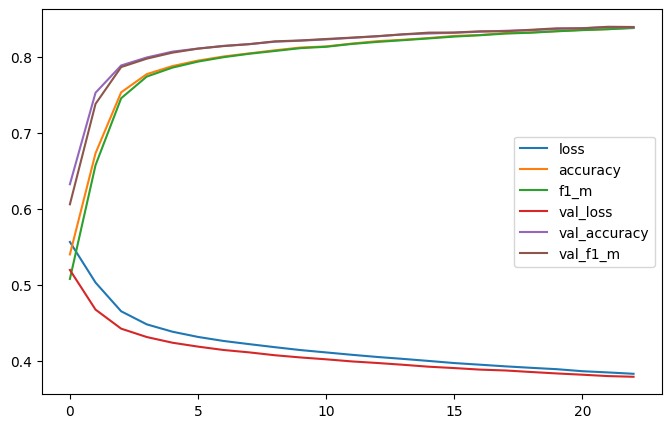

In [27]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

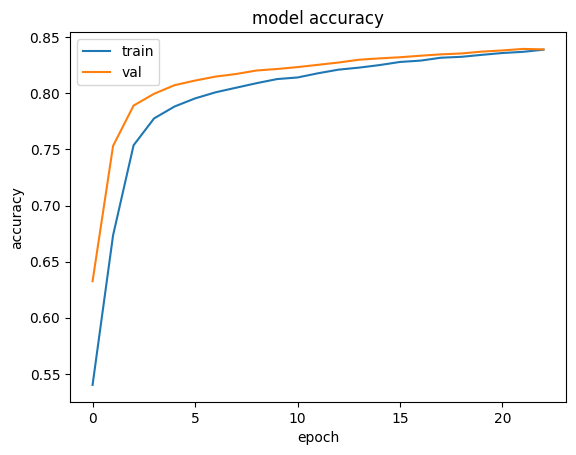

In [28]:
#plot model accuracy on training and validation set

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

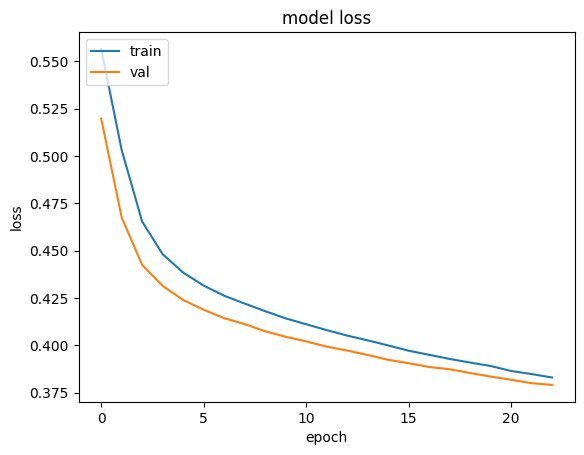

In [29]:
#plot loss curves, validataion and training loss curves
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [30]:
#evaluate model on test set
results = model.evaluate([x_test_int_np,x_test_masks_np], y_test)
print(results)


2070/2070 [==============================] - 66s 30ms/step - loss: 0.3804 - accuracy: 0.8379 - f1_m: 0.8380
[0.38042426109313965, 0.8378643989562988, 0.8380480408668518]


In [32]:
#compute predicted values
y_prediction = model.predict([x_test_int_np,x_test_masks_np])
y_prediction = np.argmax (y_prediction, axis = 1)
y_test=np.argmax(y_test, axis=1)

#Create confusion matrix and normalizes it over predicted (columns)
result = metrics.confusion_matrix(y_test, y_prediction , normalize='pred')
print(result)

2070/2070 [==============================] - 50s 22ms/step
[[0.87054158 0.14971373 0.11168624]
 [0.11474289 0.81646161 0.18335656]
 [0.01471554 0.03382466 0.7049572 ]]


In [57]:

report = classification_report(y_test, y_prediction, target_names=["Positive", "Neutral", "Negative"])
print(report)

              precision    recall  f1-score   support

    Positive       0.87      0.88      0.88     36075
     Neutral       0.82      0.80      0.81     25223
    Negative       0.70      0.72      0.71      4912

    accuracy                           0.84     66210
   macro avg       0.80      0.80      0.80     66210
weighted avg       0.84      0.84      0.84     66210



**Visualizing Aspect-Sentiment Distribution Based on the Reviews Dataset**

**Word Cloud**

Word cloud is used to identify the most frequently occuring aspects

In [34]:
from wordcloud import WordCloud

def wc(data,bgcolor,title):
    plt.figure(figsize = (80,80))
    wc = WordCloud(background_color = bgcolor, max_words = 300,  max_font_size = 80)
    wc.generate(' '.join(data))
    plt.imshow(wc)
    plt.axis('off')

In [35]:
a = dropped_result['aspect']


a = a[a.apply(lambda x: isinstance(x, float))]
len(dropped_result)

331046

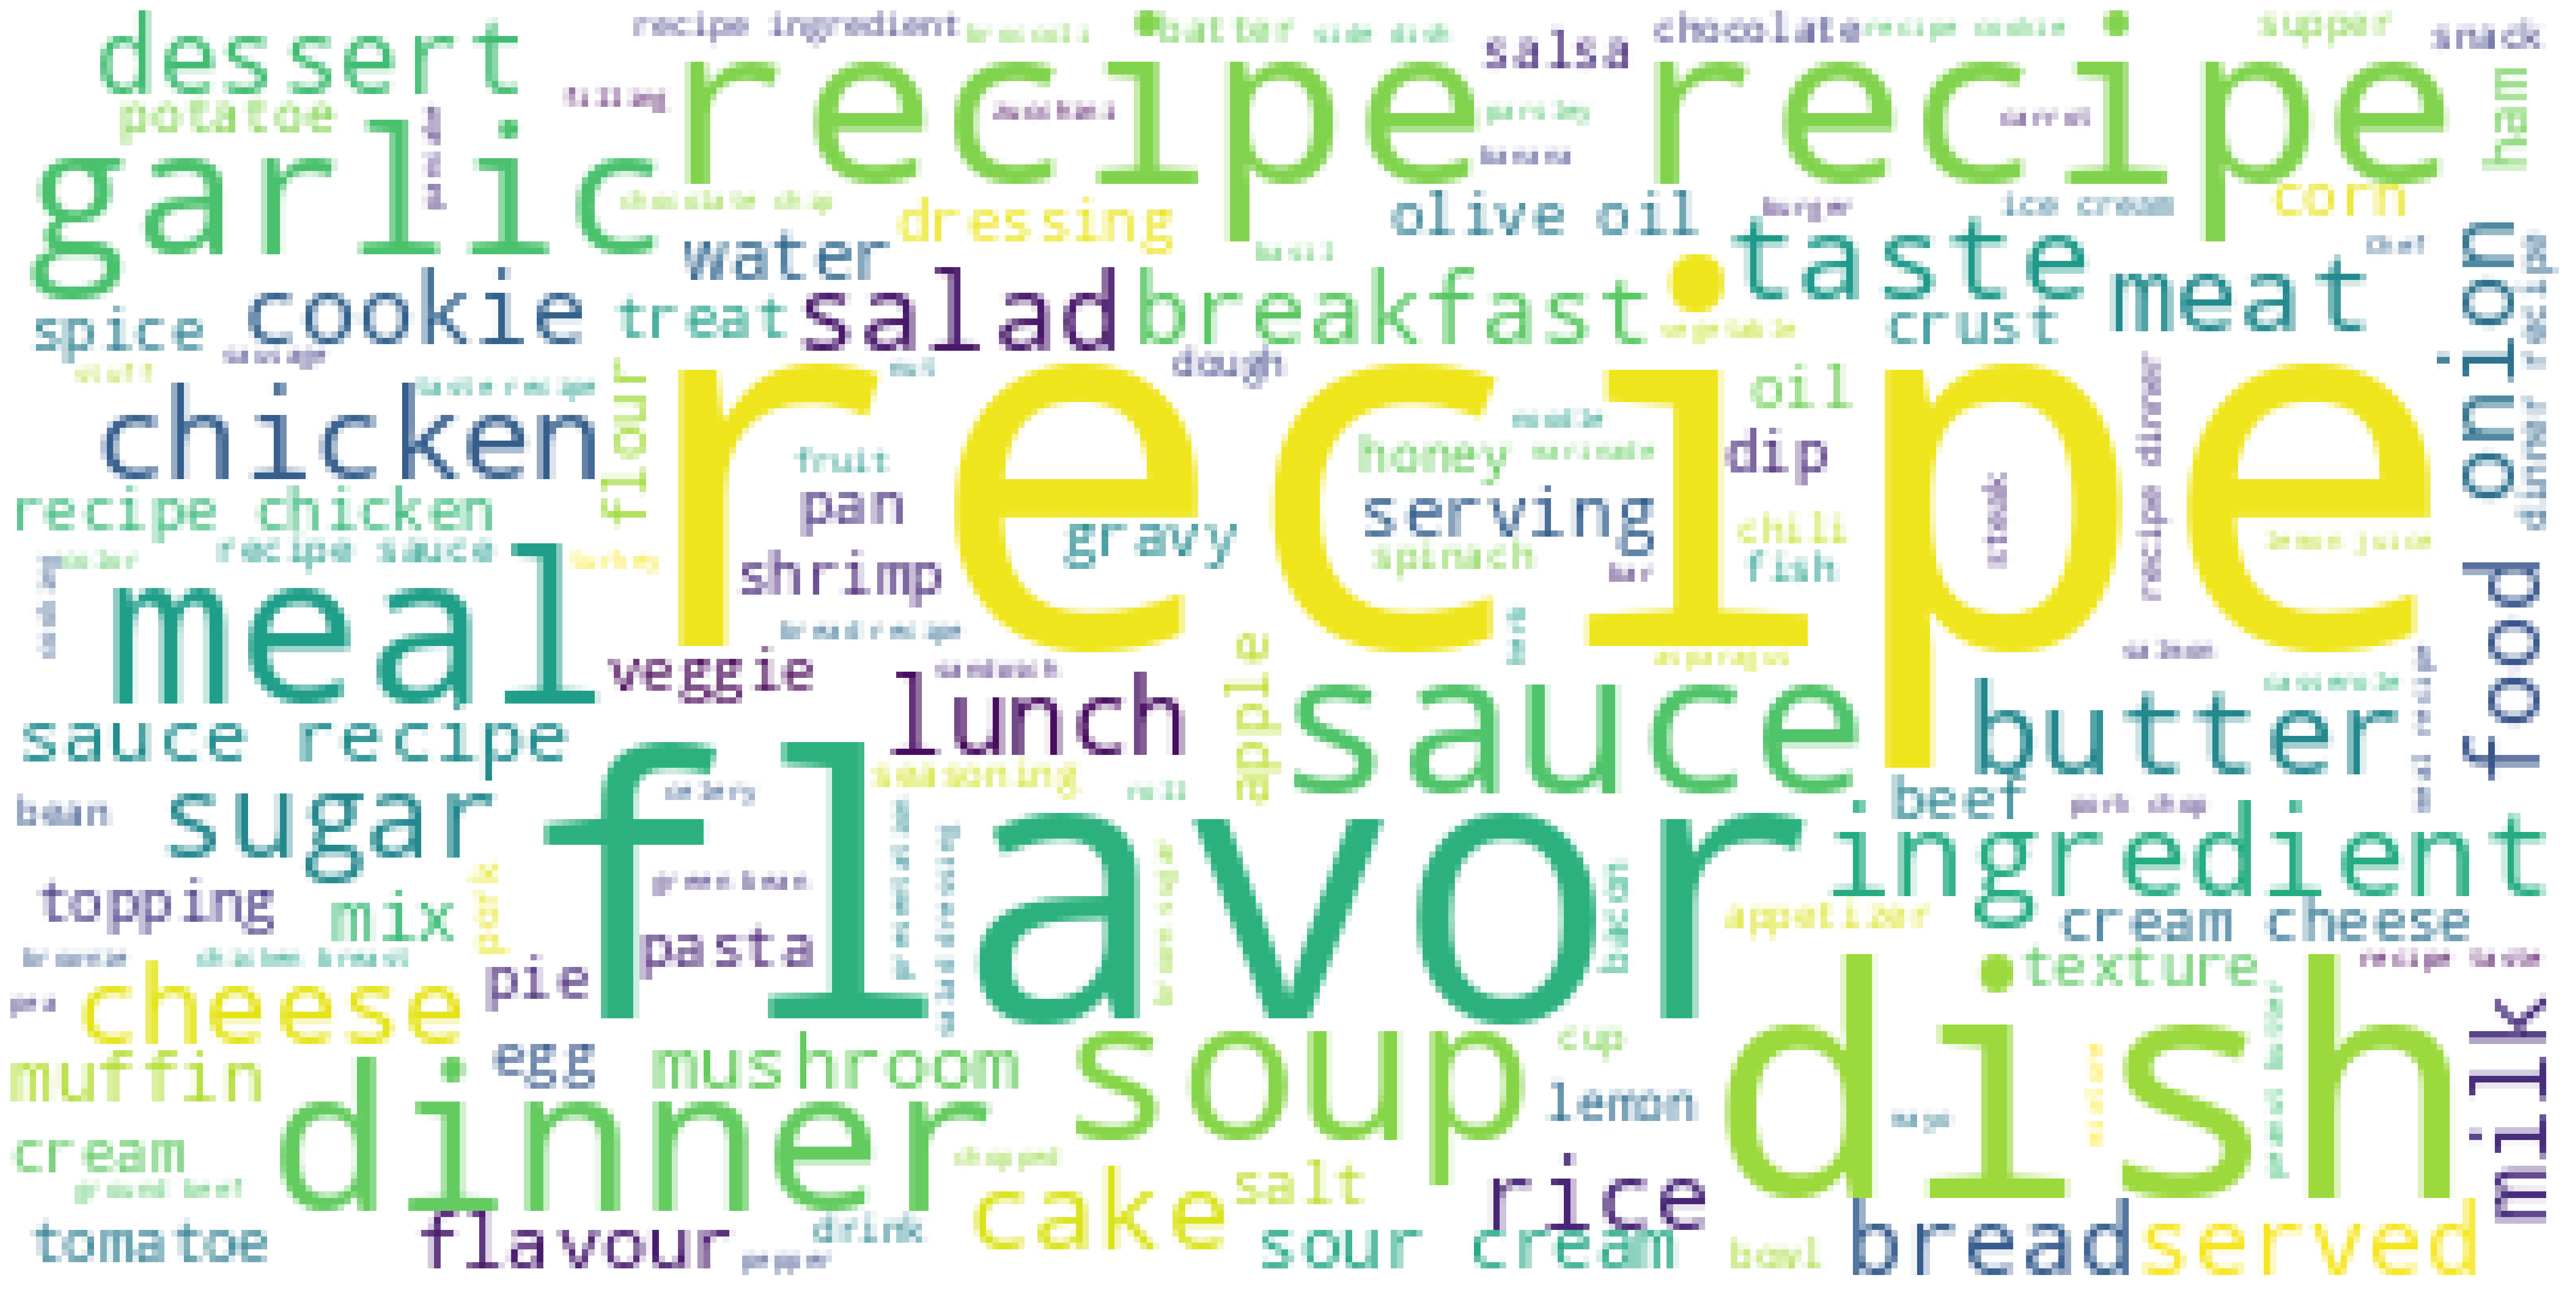

In [36]:
wc(dropped_result['aspect'],'white','Common Words' )

**Aspect Sentiment Distribution with Bar Charts**



Aspect Sentiment Distribution:

Create a bar chart showing the sentiment distribution for each aspect (e.g., taste, presentation, ease of preparation).
Insights: Identify aspects with the most positive and negative sentiments. This can help highlight what aspects users appreciate the most and areas for improvement.

In [37]:
#asdist = dropped_result.head(100)


In [ ]:
asp = dropped_result.set_index(['aspect'])

#most frequently occurring aspects: give general appraisal of the recipes
top_rev = asp.loc[asp.index.isin(['recipe', 'flavour', 'taste', 'meal', 'dish'])]

#most frequently occuring ingredients
ingredients_rev = asp.loc[asp.index.isin(['sugar', 'chicken', 'garlic', 'meat', 'meat', 'onion', 'milk', 'rice'])]

#aspect-sentiment distribution of some aspects that refer to some vegetables
veggies_rev = asp.loc[asp.index.isin(['vegetable', 'carrots', 'salad', 'tomatoes', 'spinach'])]

In [52]:
#asp = asdist.set_index(['aspect'])

#asp = dropped_result.set_index(['aspect'])

#asp = asp.loc[asp.index.isin(['bean sprouts', 'pizza'])]
#asp = asp.loc[asp.index.isin(['steps', 'Challenging', 'Complex', 'Complicated', 'Tricky', 'Laborious', 'Time-consuming', 'Confusing', 'Tedious', 'Technical', 'Frustrating',
                             # 'Demanding', 'Not beginner-friendly', 'Advanced', 'ingredients', 'time'])]

#asp = asp.loc[asp.index.isin(['beef', 'chicken', 'duck', 'fish', 'shrimp', 'lamb', ])]
##asp = asp.loc[asp.index.isin(['taste', 'presentation', 'version', 'style'])]

#asp = asp.loc[asp.index.isin(['beef', 'chicken', 'duck', 'fish', 'shrimp', 'lamb', 'tofu', 'beans', 'soy' ])]

#asp = asp.loc[asp.index.isin(['honey', 'sugar'])]

#asp = asp.loc[asp.index.isin(['honey', 'sugar'])]

#asp = asp.loc[asp.index.isin(['vegetable', 'carrots', 'salad', 'tomatoes', 'spinach'])]

#asp = asp.loc[asp.index.isin(['breakfast', 'lunch', 'dinner', 'super', 'brunch'])]

#asp = asp.loc[asp.index.isin(['recipe', 'process', 'steps'])]

#asp = asdist.loc[asdist['aspect'].isin(['cheese', 'pizza'])]


#asp.head()

,sentence,sentiment,position
aspect,,,
dish,An excellent dish .,Positive,[2]
recipe,Would someone please check the Nutrition Facts...,Neutral,[9]
recipe,Very simple recipe to make ! This is a refresh...,Positive,[2]
recipe,This recipe was really easy to follow and was ...,Positive,[1]
recipe,"Your recipe was wonderful , it all fit togethe...",Positive,[1]


In [53]:
aspect_sentiment_distribution = ingredients_rev.groupby(['aspect', 'sentiment']).size().unstack().fillna(0)

In [ ]:
aspect_sentiment_distribution

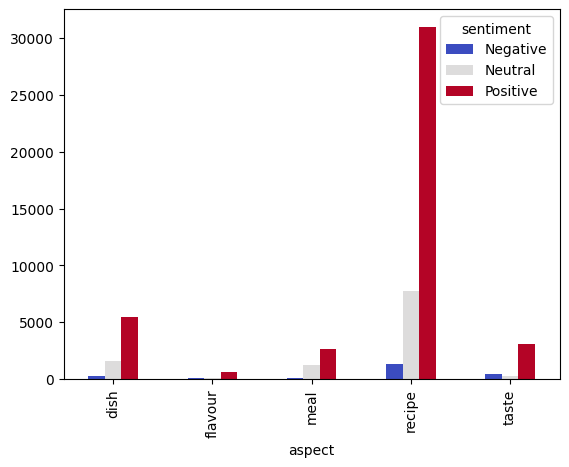

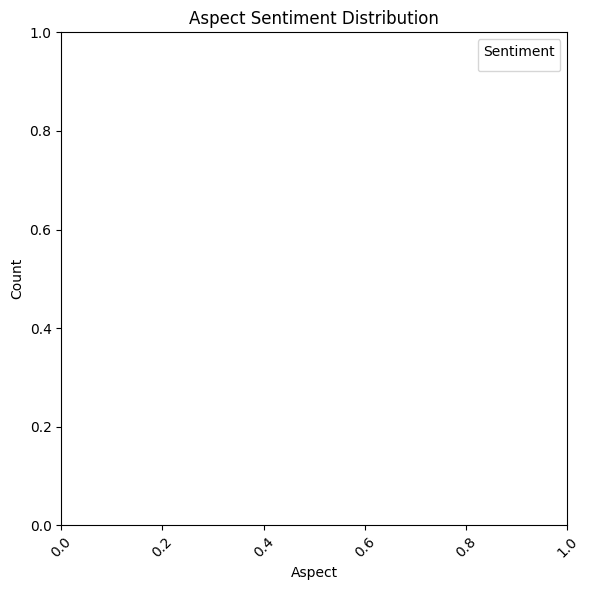

In [54]:
import matplotlib.pyplot as plt

# Plotting the bar chart
aspect_sentiment_distribution.plot(kind='bar', colormap='coolwarm')
plt.figure(figsize=(6,6))
plt.xlabel('Aspect')
plt.ylabel('Count')
plt.title('Aspect Sentiment Distribution')
plt.legend(title='Sentiment', loc='upper right', labels=['Negative', 'Neutral', 'Positive'])
plt.xticks(rotation=45)
plt.tight_layout()


# Display the plot
plt.show()


**Aknowledgement:**

The code used in this research was inspired by an adapted from a final assesment task for a module in the course of this Course Program.